In [2]:
%matplotlib inline
import re
import nltk
nltk.download('stopwords')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
plt.rcParams['figure.figsize'] = (10, 6)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ícaro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


## Equipe
### Ícaro de Lima - 385194 <br> Thalisson Felipe - 390195

# 1. Importar e separar o conjunto de dados fornecido em treinamento e teste

### Dataset
O conjunto de dados que importamos e trabalhamos consiste de uma análise de notícias reais e falsas. Conforme vemos abaixo, temos o título da notícia, o texto do corpo da notícia e por fim uma label com as classificações de cada notícia - REAL se forem reais e FAKE se forem notícias falsas. Nosso objetivo é trabalhar com o dataset de tal maneira que possamos analisar a presença de certas palavras que podem ser mais ou menos frequentes em notícias falsas ou reais. Em outras palavras, iremos desenvolver um modelo de predição para classificar se uma notícia é real ou falsa.

In [3]:
df = pd.read_csv('noticias.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


Nessa primeira parte após importamos o dataset, realizamos dois processamentos nos dados:
- Criamos um nova variável X representando a concatenação das strings title e text do dataset. Por exemplo: <i>You Can Smell Hillary’s Fear Daniel Greenfield, a Shillman Journalism Fello...</i> seria o primeiro elemento de X.
- Em segundo, substituímos os labels FAKE e REAL por uma representação binária 0 e 1, respectivamente.

O primeiro processo nos garante um menor número de features, concatenando as duas anteriores em apenas uma com o texto integral (título e corpo) da notícia. Como iremos trabalhar com a frequência das palavras nas notícias, não há problema em utilizarmos apenas uma feature para abrigar todo o texto relativo a notícia em questão.
Já no segundo processamento, fazemos apenas uma transformação de valores. Ao invés de trabalharmos com strings, uma vez que as classificações são binárias - isto é, ou uma notícia é <b>Real (1)</b> ou <b>Falsa (0)</b> -, é mais simples trabalharmos com uma variável binária, agilizando o processamento e consumindo menos alocação de recursos. 

In [4]:
X, y = (df['title'] +  ' ' + df['text']).values, df['label'].replace(['FAKE', 'REAL'], [0, 1]).values

Nos passos 2 e 3 vamos utilizar o <b>CountVectorizer</b> e o <b>TfidfVectorizer</b> com seus parâmetros default. Nesse caso, todas as strings são transformadas em lowercase - para que não haja nenhum tipo de case sensitivity - e não é utilizado nenhum "stopwords". A codificação utilizada foi a utf-8.

# 2. Criar uma matriz vetorizada que represente os textos utilizando o CountVectorizer

In [24]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(X)

O resultado do <b>CountVectorizer</b> é uma matriz baseada na combinação de valores de frequência de cada palavra. Por exemplo, em uma determinada notícia a palavra "and" aparece 1000 (mil) vezes e "flat" aparece 100 (cem) vezes, o CountVectorizer retornara valores que identifiquem a maior incidencia da palavra "and" do que da palavra "flat".

# 3. Criar uma matriz vetorizada que represente os textos utilizando o TfidfVectorizer

In [6]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X)

Já o resultado do <b>TfidfVectorizer</b> é um pouco diferente. Ainda consiste em uma matriz baseada na combinação de valores de frequência de cada palavra. Entretanto, existe uma ponderação para as palavras de forma que seja possível refletir a relevância destas. Por exemplo, em uma determinada notícia a palavra "and" aparece 1000 (mil) vezes e "flat" aparece 250 (duzentos e cinquenta) vezes, já vimos que o CountVectorizer retornará valores que identifiquem a maior incidencia da palavra "and" do que da palavra "flat". Mas se pararmos para pensar, "and", "the", "a", etc. são palavras muito frequentes em notícias por se tratarem de artigos definidos, indefinidos, conectivos e assim por diante. Esses tipos de expressões podem sim influenciar na classificação de uma notícia, mas é nítido que elas são inerentes a língua e estarão presentes na maioria das notícias, independente da label. Da mesma maneira que, "flat" - apesar de uma menor frequência no texto - possui uma relevância maior para a notícia e também para sua classificação. Esse tipo de ponderação nos tipos de palavra, procurando compensar e refletir melhor esta relevância, é exatamente o diferencial do TfidfVectorizer. 

# 4. Criar dois modelos para classificar os textos utilizando o algoritmo Naive Bayes (multinomial) utilizando o CountVectorizer e o TfidfVectorizer

Como proposto pelo trabalho, utilizamos o train_test_split do sklearn para separar nossos dados em dados de treino e dados de teste. A função fit_transfor utilizada acima retorna uma sparse, que são matrizes com muitos valores 0. Não transformamos a matriz para um numpy porque sparse matrix podem ser muito grandes e podem ocasionar problemas relacionados a memória.

O algoritmo Naive Bayes é um algoritmo baseado no teorema de Bayes e é bastante utilizado para a classificação de textos baseados na frequência das palavras usadas. Isto porque ele acaba sendo mais simples e mais rápido do que outros algoritmos de classificação, principalmente para a solução deste trabalho. Outro ponto característico do Naive Bayes é o fato do algoritmo desconsiderar a correlação entre as features do dataset, ou seja, trata cada feature de forma independente.

Nos passos 4.1 e 4.2 criamos nossos dados de treino e de teste, utilizando um tamanho de 40% do dataset para os dados de teste. Em seguida, criamos o modelo e fitamos com os dados de treino.

## 4.1 Naive Bayes utilizando o CountVectorizer

In [27]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(count_matrix, y, test_size=0.4, random_state=42)
clf1 = MultinomialNB().fit(X_train1, y_train1)

## 4.2 Naive Bayes utilizando o TfidfVectorizer

In [28]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(tfidf_matrix, y, test_size=0.4, random_state=42)
clf2 = MultinomialNB().fit(X_train2, y_train2)

# 5. Comparar os resultados utilizando a precisão e a Matriz de Confusão

In [29]:
def show_frequencies(confusion_matrix):
    print('True Negatives (TN):', confusion_matrix[0][0])
    print('False Negatives (FN):', confusion_matrix[1][0])
    print('True Positives (TP):', confusion_matrix[1][1])
    print('False Positives (FP):', confusion_matrix[0][1])

A definição do sklearn de precisão é a taxa <br> $$ \frac{TP}{ (TP + FP)} $$ <br>onde TP é o númemro de true positives (verdadeiro positivos) e FP é o número de false positives (falso positivos). Verdadeiro positivo são itens rotulados corretamente como positivos e Falso positivo que são itens rotulados incorretamente como positivos.

A matriz de confusão é uma tabela que mostra as frequências de classificação para cada classe. Acima já foram ditos duas frequências: **TP** e **FP**. Mas também existem outras duas: **TN** e **FN**. TN é o número de true negatives (verdadeiro negativos) que são itens rotulados corretamente como negativos e FN é o número de false negatives (falso negativos) que são itens rotulados incorretamente como negativos.

True Negatives (TN): 1105
False Negatives (FN): 180
True Positives (TP): 1157
False Positives (FP): 92


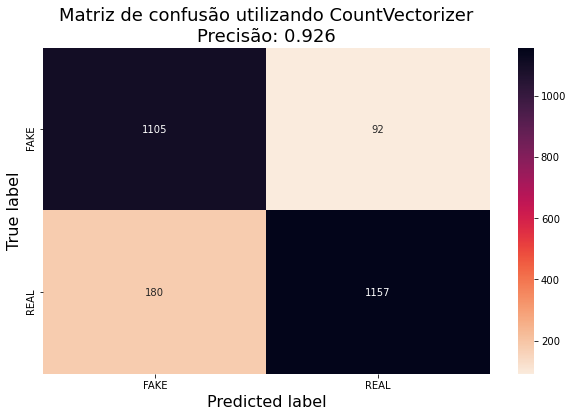

In [37]:
y_pred1 = clf1.predict(X_test1)
precision1 = precision_score(y_pred1, y_test1)
cm1 = confusion_matrix(y_pred1, y_test1)
show_frequencies(cm1)
cm1_df = pd.DataFrame(cm1, index=['FAKE','REAL'], columns=['FAKE','REAL'])

sns.heatmap(cm1_df, annot=True, cmap = 'rocket_r', fmt='d')
plt.title('Matriz de confusão utilizando CountVectorizer\nPrecisão: {0:.3f}'.format(precision1), fontsize=18)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.show()

True Negatives (TN): 672
False Negatives (FN): 613
True Positives (TP): 1244
False Positives (FP): 5


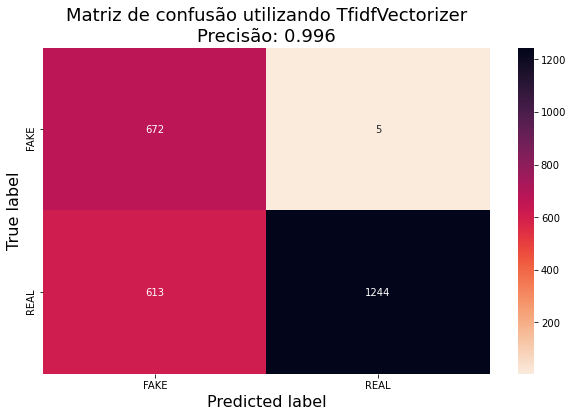

In [38]:
y_pred2 = clf2.predict(X_test2)
precision2 = precision_score(y_pred2, y_test2)
cm2 = confusion_matrix(y_pred2, y_test2)
show_frequencies(cm2)
cm2_df = pd.DataFrame(cm2, index=['FAKE','REAL'], columns=['FAKE','REAL'])

sns.heatmap(cm2_df, annot=True, cmap = 'rocket_r', fmt='d')
plt.title('Matriz de confusão utilizando TfidfVectorizer\nPrecisão: {0:.3f}'.format(precision2), fontsize=18)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.show()

Obtivemos quase 100% de precisão utilizando o TfidfVectorizer no nosso classificador. Porém esse cálculo leva em consideração somente os True Positives e os False Positives (precision = tp / (tp + fp)). Os false positivos foram só 5, por isso a precisão foi bem alta. Mas o modelo classificou 613 notícias como FAKE que na verdade eram para ser classificadas como REAL.

O CountVectorizer conta apenas o número de vezes que a palavra aparece no documento e isso pode resultar em um enviesamento em favor dessas palavras. Por esse motivo acaba-se ignorando palavras raras que poderiam ter ajudado no processamento dos dados de forma mais eficiente. O TfidfVectorizer considera o peso geral da sentença de uma palavra. Logo, as palavras que são mais frequentes são penalizadas. Ou seja, o TfidfVectorizer pondera as contagens de palavras usando a frequência com que essas palavras aparecem nas sentenças.

# 6. [BÔNUS] Propor passos adicionais para melhorar os resultados encontrados

Os passos adicionais que utilizamos para melhorar os resultados foi realizar um melhor pré-processamentos nos dados. Para isso, utilizamos o nltk (um conjunto de bibliotecas e programas para processamento simbólico e estatístico da linguagem natural para inglês) e algumas técnicas para limpar nossos dados.

Na célula abaixo definimos um conjunto com stopwords - palavras que não adicionam sentido ao texto, pois são usadas para coesão e dar contexto, mas não fazem sentido específico quando olhadas individualmente. Exemplos de stopwords: a, about, then, are... Também instanciamos a classe PorterStemmer do nltk - stemming ou stemização é o processo de reduzir palavras flexionadas a sua forma stem (base). Por exemplo:
- likes
- liked
- likely
- liking

Todas essas palavras após o processo de stemming são transformadas na palavra "like" que é sua forma base.

In [39]:
stopwords_ = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()

A função abaixo stemmer tem três objetivos:
- Transforma cada palavra para lowercase
- Verifica se a palavra pertence ao conjunto de stopwords_, ignora a palavra se pertencer.
- Aplica o processo de stemização na palavra

In [40]:
def stemmer(sentence, use_stopwords=False):
    output = []
    for word in sentence.split(' '):
        word = word.lower()
        if use_stopwords:
            if word not in stopwords_:
                output.append(porter_stemmer.stem(word))
        else:
            output.append(porter_stemmer.stem(word))

    return ' '.join(output)

A função preprocess tem três objetivos:
- Chama a função stemmer para cada frase do conjunto de dados
- Remove pontuações, caracteres especiais e números
- Remove espaços duplicados caso existam

In [41]:
def preprocess(X, use_stopwords=False):
    X_processed = []
    for string in X:
        x_processed = stemmer(string, use_stopwords)
        x_processed = re.sub('[^a-zA-Z]', ' ', x_processed)
        x_processed = re.sub('(\s+)', ' ', x_processed)
        X_processed.append(x_processed)

    return X_processed

Todos os passos listados acima foram os pré-processamentos realizados no dataset. X_processed é produto disso e será usado como entrada para o CountVectorizer e o TfidfVectorizer.

## 6.1 Naive Bayes utilizando o CountVectorizer

In [42]:
X_processed1 = preprocess(X, use_stopwords=True)

In [45]:
new_count_vectorizer = CountVectorizer()
new_count_matrix = new_count_vectorizer.fit_transform(X_processed1)

In [46]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(new_count_matrix, y, test_size=0.4, random_state=42)
clf3 = MultinomialNB()
clf3.fit(X_train3, y_train3)

MultinomialNB()

True Negatives (TN): 1121
False Negatives (FN): 164
True Positives (TP): 1163
False Positives (FP): 86


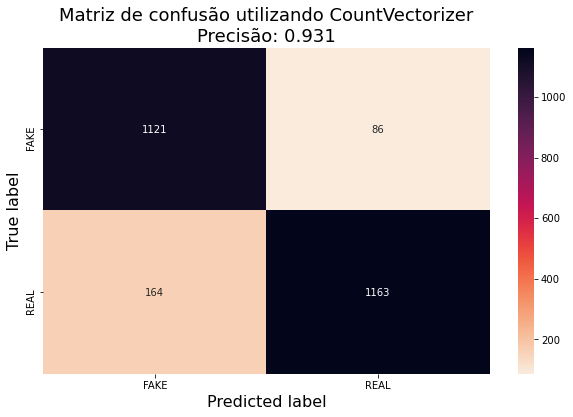

In [47]:
y_pred3 = clf3.predict(X_test3)
precision3 = precision_score(y_pred3, y_test3)
cm3 = confusion_matrix(y_pred3, y_test3)
show_frequencies(cm3)
cm3_df = pd.DataFrame(cm3, index=['FAKE','REAL'], columns=['FAKE','REAL'])

sns.heatmap(cm3_df, annot=True, cmap = 'rocket_r', fmt='d')
plt.title('Matriz de confusão utilizando CountVectorizer\nPrecisão: {0:.3f}'.format(precision3), fontsize=18)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.show()

Podemos ver que com esses processamentos obtivemos um resultado de precisão um pouco melhor utilizando o CountVectorizer. Uma mudança de 0.926 para 0.931.

## 6.2 Naive Bayes utilizando o TfidfVectorizer

Para o TfidfVectorizer, não utilizamos as stopwords porque obtivemos um pior resultado. Sem as stopwords, obtivemos um aumento de 1% na precisão. Isto muito provavelmente já ocorre em função do próprio ponderamento que o método faz justamente nos tipos de palavras que atribuimos ao stopwords, ou seja, é como se isso já estivesse sendo considerado na própria implementação do TfidfVectorizer.

In [48]:
X_processed2 = preprocess(X)

In [49]:
new_tfidf_vectorizer = TfidfVectorizer()
new_tfidf_matrix = new_tfidf_vectorizer.fit_transform(X_processed2)

In [50]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(new_tfidf_matrix, y, test_size=0.4, random_state=0)
clf4 = MultinomialNB()
clf4.fit(X_train4, y_train4)

MultinomialNB()

True Negatives (TN): 662
False Negatives (FN): 605
True Positives (TP): 1263
False Positives (FP): 4


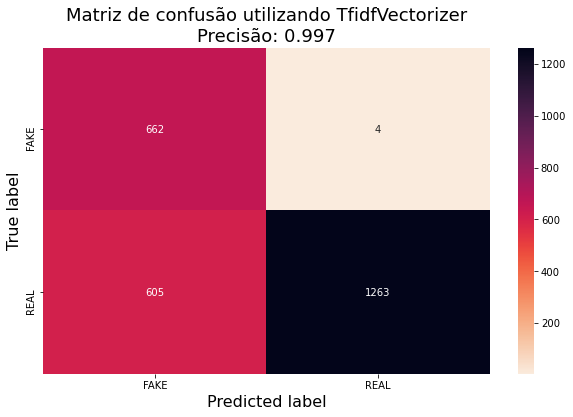

In [51]:
y_pred4 = clf4.predict(X_test4)
precision4 = precision_score(y_pred4, y_test4)
cm4 = confusion_matrix(y_pred4, y_test4)
show_frequencies(cm4)
cm4_df = pd.DataFrame(cm4, index=['FAKE','REAL'], columns=['FAKE','REAL'])

sns.heatmap(cm4_df, annot=True, cmap = 'rocket_r', fmt='d')
plt.title('Matriz de confusão utilizando TfidfVectorizer\nPrecisão: {0:.3f}'.format(precision4), fontsize=18)
plt.ylabel('True label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)
plt.show()

Podemos ver que com esses processamentos obtivemos um resultado de precisão um pouco melhor utilizando o TfidfVectorizer. Uma mudança de 0.996 para 0.997.

# Conclusão

Primeiramente nós tratamos os dados de uma maneira que ficasse mais adequado para a análise proposta. Em seguida, começamos com a criação das matrizes vetorizadas de representação do texto baseado na frequência das palavras. Para isto, utilizamos dois métodos: o **CountVectorizer** e o **TfifVectorizer**. O Primeiro simplesmente considera as frequências de incidencia das palavras, enquanto o segundo pondera as palavras para que reflita a relevância delas para o texto.

Adiante, treinamos e testamos o modelo para cada um dos dois métodos (*CountVectorizer* e o *TfifVectorizer*) e analisamos cada um em relação as suas respectivas precisões. Relembrando que: <br> $$ Precisão = \frac{TP}{ (TP + FP)} $$ <br>
Em todas os casos, o método **TfifVectorizer** retornou melhores resultados de precisão do que o **CountVectorizer**. O que era de se esperar, dado a caracterização de cada um destes.
Por fim, como bônus, reimplementamos os métodos e o classificador naive bayes para o caso de usarmos uma lista de stopwords. Ainda assim, o resultado da precisão obtida com o **TfifVectorizer** continuou sendo o melhor.

Podemos concluir então, pelos resultados obtidos neste trabalho, que o método para o modelo e o conjunto de dados em questão, que retorna a melhor precisão, é o **TfifVectorizer**, sendo assim o mais indicado para o caso.

E com isso, encerramos o nosso trabalho.
Obrigado!